In [1]:
import os
import sys
# Add project root (one level up from data_analysis) to sys.path
sys.path.append(os.path.abspath('..'))

import numpy as np
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.stats import linregress

from helper import file_preprocesser

In [3]:
#Funktionen 
def group_by_power_of_two(deg_prob_dict, group_method="lower"):
    max_deg = max(deg_prob_dict.keys())
    bucket_dict = dict()
    for deg, prob in deg_prob_dict.items():
        if group_method == "lower":
            bucket = 2 ** int(np.floor(np.log2(deg)))
        elif group_method == "upper":
            bucket = 2 ** int(np.ceil(np.log2(deg)))
        #print(str.format("deg: {0}, bin: {1}", deg, bucket))
        if bucket not in bucket_dict:
            bucket_dict[bucket] = prob
        else:
            bucket_dict[bucket] = bucket_dict[bucket] + prob
    print(str.format("Anzahl der Knotengrade: {0}, max degree: {1}, Anzahl Buckets: {2}", len(deg_prob_dict), max_deg, len(bucket_dict)))
    return bucket_dict
	
def get_deg_probability_dict(graph):
    deg_frequency_list = np.array(nx.degree_histogram(graph))
    total_nodes = graph.order()
    res = {}
    for deg in range(len(deg_frequency_list)):
        if deg_frequency_list[deg] == 0: continue
        else:
            res[deg] = deg_frequency_list[deg] / total_nodes
    return res

def filter_deg_prob_dict(deg_prob_dict, min_deg, max_deg=0):
    """" 
    filters degree-probability dictionary by key, min and max param-values are included in result.
    """
    return {k: v for k, v in deg_prob_dict.items() if k >= min_deg and (max_deg == 0 or k <= max_deg)}

def lin_reg_on_grouped_deg_prob_dict(grouped_dict):
    sorted_dict = dict(sorted(grouped_dict.items()))
    x_values = list(sorted_dict.keys())
    y_values = list(sorted_dict.values())
    return lin_reg_on_deg_prob_lists(x_values, y_values)

def lin_reg_on_deg_prob_lists(x_values, y_values):
    #print("x_values: ", x_values)
    #print("y_values: ", y_values)
    #convert to log scale
    x_values = np.log10(x_values)
    y_values = np.log10(y_values)
    lin_reg_results = linregress(x_values, y_values)
    # results contain: slope, intercept (y-axis cutting point), rvalue, pvalue, stderr
    return lin_reg_results

def find_regiment_candidates_linreg(deg_prob_dict, start=0, stop=0, step=1, max_diff=5, group_method="lower"):
    """
    Outliers must be removed in advance! 
    start param only controls where we begin checking for regiments. It will still include the values < start!!
    """
    bucket_dict = group_by_power_of_two(deg_prob_dict, group_method=group_method)
    #print("bucket dict: ", bucket_dict)
    sorted_tuple_list = [(bucket, bucket_dict[bucket]) for bucket in sorted(bucket_dict.keys())]
    #print("sorted tuple list: ", sorted_tuple_list)
    res = dict()

    for i in range(start, stop if stop != 0 else len(sorted_tuple_list), step):
        left = sorted_tuple_list[:i+1] #splitting point will be included in left side
        right = sorted_tuple_list[i+1:]
        if len(left) <= 1 or len(right) <= 1: #at least one bucket per side
            print("skipping i: ", i)
            continue
        bins_left = [t[0] for t in left]
        probs_left = [t[1] for t in left]
        bins_right = [t[0] for t in right]
        probs_right = [t[1] for t in right]

        results_left = lin_reg_on_deg_prob_lists(bins_left, probs_left)
        results_right = lin_reg_on_deg_prob_lists(bins_right, probs_right)
        split_value = bins_left[-1]
        res[split_value] = { "slope_left": results_left.slope, 
                  "intercept_left": results_left.intercept,
                  "slope_right": results_right.slope,
                  "intercept_right": results_right.intercept
                  }

    #sort by difference between left-right regiment, descending
    res = dict(filter(lambda item: abs(item[1]["slope_left"] - item[1]["slope_right"]) <= max_diff, res.items()))
    res = dict(sorted(
        res.items(), 
        key=lambda item: abs(item[1]["slope_left"] - item[1]["slope_right"]),
        reverse=True
        ))
    return res

#for convenience
def print_regiment_candidates(regiment_candidate_dict):
    for split_at, vals in regiment_candidate_dict.items():
        print(str.format("Cut bei Trennwert {0} -> Links slope / intercept: {1:.3f} / {2:.1f} | Rechts slope / intercept: {3:.3f} / {4:.1f}", 
                        split_at,
                        vals["slope_left"], vals["intercept_left"],
                        vals["slope_right"], vals["intercept_right"]))
        

def get_powerlaw_for_interval(G: nx.Graph, min_deg=0, max_deg=0, x_min=None):
    deg_list = [ t[1] for t in G.degree() if t[1] >= min_deg and (max_deg == 0 or t[1] <= max_deg) ]
    powerlaw_results = powerlaw.Fit(deg_list, xmin=x_min)
    return powerlaw_results

def plot_grouped_single_regiment(grouped_dict, slope, intercept):
    x = np.array(list(grouped_dict.keys()), dtype=int)
    y = np.array(list(grouped_dict.values()), dtype=float)
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="deg(k) gruppiert in Zweierpotenzen")

    x_values_line = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
    y_values_line = 10 ** (slope * np.log10(x_values_line) + intercept)
    plt.plot(x_values_line, y_values_line, color="red", label=str.format("{0:.4f}", slope))

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True, which="major", ls="--", lw=0.5)
    plt.legend()
    plt.title("Verteilung der ")
    plt.show()
    return

def plot_grouped_two_regiments(grouped_dict, split_at, slope_first_regiment, intercept_first_regiment, slope_second_regiment, intercept_second_regiment):
    x = np.array(list(grouped_dict.keys()), dtype=int)
    y = np.array(list(grouped_dict.values()), dtype=float)
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="grouped")

    x_values_first_regiment = np.logspace(np.log10(min(x)), np.log10(split_at), 100)
    y_values_first_regiment = 10 ** (slope_first_regiment * np.log10(x_values_first_regiment) + intercept_first_regiment)
    plt.plot(x_values_first_regiment, y_values_first_regiment, color="red", label=str.format("{0:.4f}", slope_first_regiment))

    x_values_second_regiment = np.logspace(np.log10(split_at), np.log10(max(x)), 100)
    y_values_second_regiment = 10 ** (slope_second_regiment * np.log10(x_values_second_regiment) + intercept_second_regiment)
    plt.plot(x_values_second_regiment, y_values_second_regiment, color="green", label=str.format("{0:.4f}", slope_second_regiment))

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True, which="major", ls="--", lw=0.5)
    plt.legend()
    plt.title("Grouped Degree Probability (log-log) with Power-Law Slopes")
    plt.show()
    return

def bar_plot_deg_prob(deg_prob_dict, titel="Degree Distribution", y_axis="decimal"):
    x = list(sorted(deg_prob_dict.keys()))
    y = [deg_prob_dict[k] for k in x]

    plt.figure(figsize=(8, 6))
    plt.bar(x, y, width=1.0)

    if y_axis == "deximal":
        # Format y-axis to use plain decimal
        plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        plt.ticklabel_format(style='plain', axis='y')  # Turn off scientific notation
    elif y_axis == "log":
        plt.yscale('log')
        
    plt.xlabel("Degree k")
    plt.ylabel("Probability P(k)")
    plt.title(titel)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def plot_both_grouped_distributions(grouped_dict, slope_single, intercept_single,
                                    split_at, slope_left, intercept_left, slope_right, intercept_right):
    x = np.array(list(grouped_dict.keys()), dtype=int)
    y = np.array(list(grouped_dict.values()), dtype=float)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # --- Left subplot: Single Regiment ---
    ax = axes[0]
    ax.scatter(x, y, label="Knotengrade gruppiert zu Zweierpotenzen", color="tab:blue")

    x_line = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
    y_line = 10 ** (slope_single * np.log10(x_line) + intercept_single)
    ax.plot(x_line, y_line, color="red", label=f"Steigung: {slope_single:.4f}")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("k")
    ax.set_ylabel("P(k)")
    ax.set_title("Potenzgesetz Annährung, gesamt")
    ax.grid(True, which="major", ls="--", lw=0.5)
    ax.legend()

    # --- Right subplot: Two Regiments ---
    ax = axes[1]
    ax.scatter(x, y, label="Knotengrade gruppiert zu Zweierpotenzen", color="tab:blue")

    x1 = np.logspace(np.log10(min(x)), np.log10(split_at), 100)
    y1 = 10 ** (slope_left * np.log10(x1) + intercept_left)
    ax.plot(x1, y1, color="red", label=f"Steigung: {slope_left:.4f}")

    x2 = np.logspace(np.log10(split_at), np.log10(max(x)), 100)
    y2 = 10 ** (slope_right * np.log10(x2) + intercept_right)
    ax.plot(x2, y2, color="green", label=f"Steigung: {slope_right:.4f}")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("k")
    ax.set_title("Potenzgesetz Annährung, aufgeteilt")
    ax.grid(True, which="major", ls="--", lw=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()


def plot_log_binned_degree_histogram(hist, deg_min=0):
    # Build degree-count dictionary with filtering
    degree_counts = {k: count for k, count in enumerate(hist) if count > 0 and k >= deg_min}

    # Group degrees into bins (powers of two)
    grouped = {}
    for deg, count in degree_counts.items():
        bucket = 2 ** int(np.floor(np.log2(deg))) if deg > 0 else 0
        if bucket > 0:
            grouped[bucket] = grouped.get(bucket, 0) + count

    # Sort bins
    x = np.array(sorted(grouped.keys()))
    y = np.array([grouped[k] for k in x])

    # Plot as bar plot
    plt.figure(figsize=(8, 6))
    plt.bar(x, y, width=0.7 * x, align='center', edgecolor='black')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("k")
    plt.ylabel("Anzahl Knoten mit deg(k)")
    plt.title("Log-Gruppierte Verteilung der Knotengrade")
    plt.grid(True, which="major", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()


## Analyse

In [ ]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.prepare_text_with_libraries(text, remove_stopwords=False, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=2)

#### Analyse eine Gerade

In [ ]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1) #remove 1 as its an outlier
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="lower")
lin_reg_results = lin_reg_on_grouped_deg_prob_dict(grouped_dict)
print("slope: ", lin_reg_results.slope)
print("intercept: ", lin_reg_results.intercept)

Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15
slope:  -0.9769625299983109
intercept:  0.07535869383418259


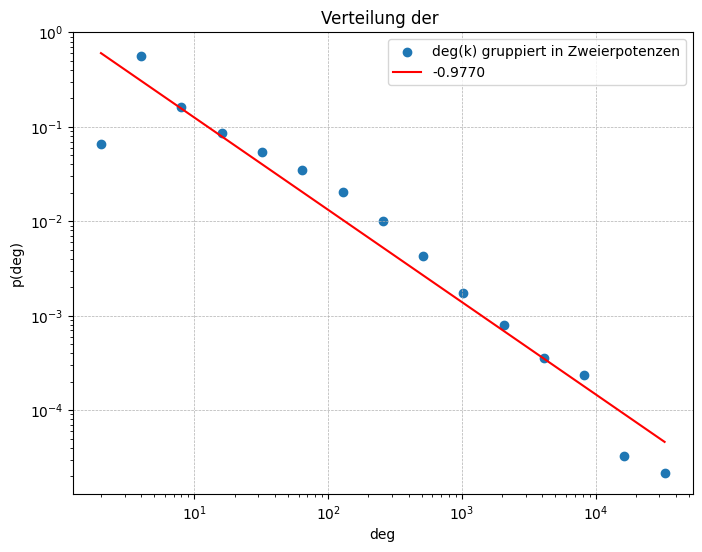

In [5]:
plot_grouped_single_regiment(grouped_dict, lin_reg_results.slope, lin_reg_results.intercept)

#### Analyse zwei Geraden

In [31]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1)
candidates = find_regiment_candidates_linreg(deg_prob_dict, start=4, stop=13 , group_method="lower", max_diff=10)


Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15


In [32]:
print_regiment_candidates(candidates)

Cut bei Trennwert 32 -> Links slope / intercept: -0.325 / -0.6 | Rechts slope / intercept: -1.211 / 0.9
Cut bei Trennwert 4096 -> Links slope / intercept: -0.852 / -0.1 | Rechts slope / intercept: -1.730 / 3.0
Cut bei Trennwert 64 -> Links slope / intercept: -0.446 / -0.5 | Rechts slope / intercept: -1.250 / 1.0
Cut bei Trennwert 128 -> Links slope / intercept: -0.526 / -0.5 | Rechts slope / intercept: -1.275 / 1.1
Cut bei Trennwert 2048 -> Links slope / intercept: -0.805 / -0.2 | Rechts slope / intercept: -1.501 / 2.0
Cut bei Trennwert 256 -> Links slope / intercept: -0.599 / -0.4 | Rechts slope / intercept: -1.292 / 1.2
Cut bei Trennwert 512 -> Links slope / intercept: -0.675 / -0.3 | Rechts slope / intercept: -1.316 / 1.3
Cut bei Trennwert 1024 -> Links slope / intercept: -0.749 / -0.2 | Rechts slope / intercept: -1.388 / 1.6
Cut bei Trennwert 8192 -> Links slope / intercept: -0.871 / -0.1 | Rechts slope / intercept: -0.585 / -2.0


Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15


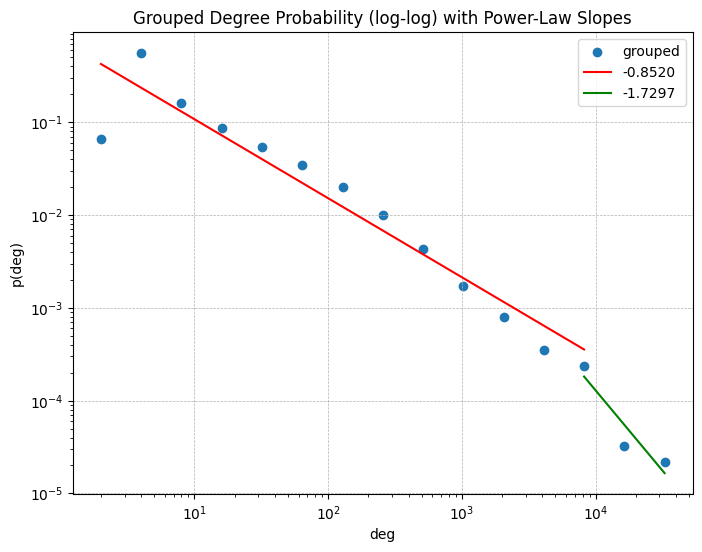

In [26]:
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="lower")
regiment_values = candidates[4096]
plot_grouped_two_regiments(grouped_dict, 8192, 
                           regiment_values["slope_left"], regiment_values["intercept_left"], 
                           regiment_values["slope_right"], regiment_values["intercept_right"])

In [27]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1)
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="upper")
candidates = find_regiment_candidates_linreg(deg_prob_dict ,group_method="upper", max_diff=10)
print_regiment_candidates(candidates)
#regiment_values = candidates[12]
#plot_grouped_two_regiments(grouped_dict, 4096, 
#                           regiment_values["slope_left"],  
#                           regiment_values["slope_right"])

Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 16
Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 16
skipping i:  0
skipping i:  14
skipping i:  15
Cut bei Trennwert 4 -> Links slope / intercept: 8.053 / -5.1 | Rechts slope / intercept: -1.007 / 0.5
Cut bei Trennwert 8 -> Links slope / intercept: 3.024 / -3.1 | Rechts slope / intercept: -1.061 / 0.7
Cut bei Trennwert 16 -> Links slope / intercept: 1.529 / -2.3 | Rechts slope / intercept: -1.112 / 0.8
Cut bei Trennwert 32 -> Links slope / intercept: 0.828 / -1.9 | Rechts slope / intercept: -1.160 / 1.0
Cut bei Trennwert 64 -> Links slope / intercept: 0.422 / -1.6 | Rechts slope / intercept: -1.208 / 1.2
Cut bei Trennwert 128 -> Links slope / intercept: 0.165 / -1.4 | Rechts slope / intercept: -1.248 / 1.4
Cut bei Trennwert 256 -> Links slope / intercept: -0.020 / -1.3 | Rechts slope / intercept: -1.274 / 1.5
Cut bei Trennwert 8192 -> Links slope / intercept: -0.599 / -0.6 | Rechts slope / intercept: -1

Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15
Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15
skipping i:  13
skipping i:  14
{'slope_left': np.float64(-0.8519629926010257), 'intercept_left': np.float64(-0.11447517662727336), 'slope_right': np.float64(-1.7297158093186487), 'intercept_right': np.float64(3.0287687401995775)}


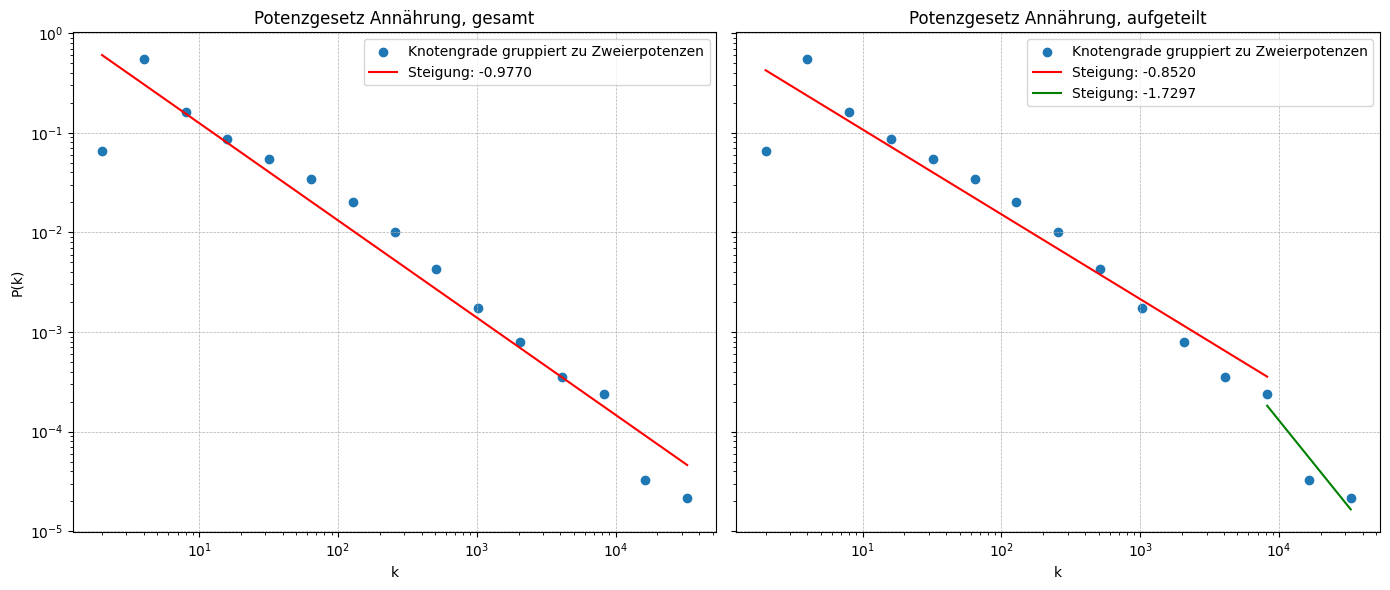

In [35]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1)
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="lower")
candidates = find_regiment_candidates_linreg(deg_prob_dict, start=4 ,group_method="lower", max_diff=10)
#print_regiment_candidates(candidates)
regiment_values = candidates[4096]
print(regiment_values)

plot_both_grouped_distributions(grouped_dict, lin_reg_results.slope, lin_reg_results.intercept,
                                8192, regiment_values["slope_left"], regiment_values["intercept_left"], 
                                regiment_values["slope_right"], regiment_values["intercept_right"])

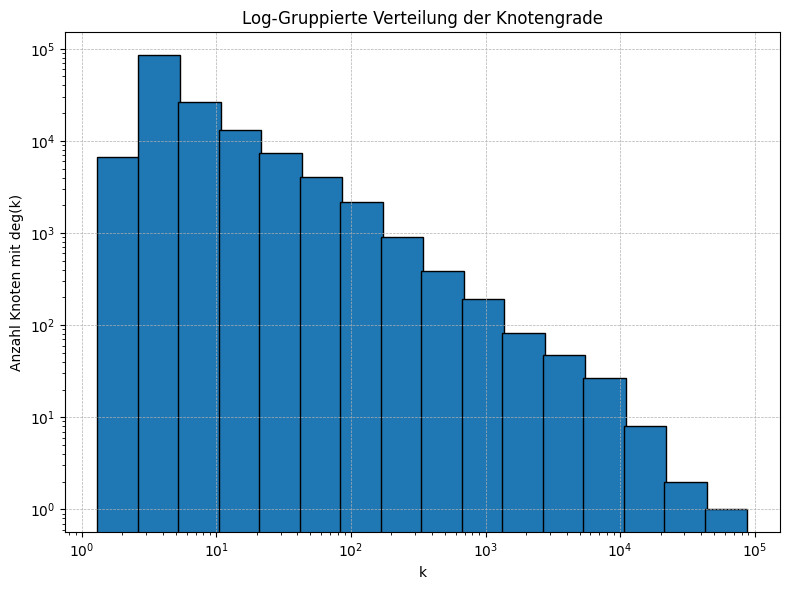

In [10]:
plot_log_binned_degree_histogram(nx.degree_histogram(G), deg_min=2)

## Analyse ohne lemmatize
- keiner sonderlich nennenswerte Unterschiede festzustellen.

In [2]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.tokenize(text, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=2)

Anzahl der Knotengrade: 1087, max degree: 83359, Anzahl Buckets: 16
slope:  -1.0156461609194551
intercept:  0.06706021325683897


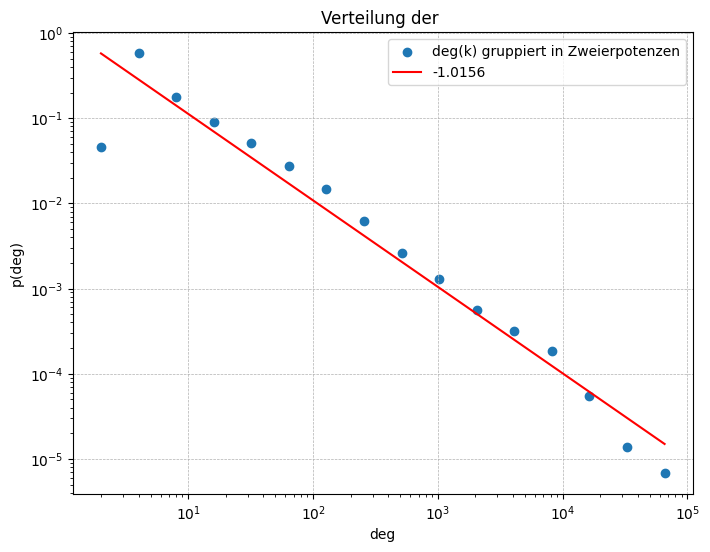

In [5]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1) #remove 1 as its an outlier
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="lower")
lin_reg_results = lin_reg_on_grouped_deg_prob_dict(grouped_dict)
print("slope: ", lin_reg_results.slope)
print("intercept: ", lin_reg_results.intercept)
plot_grouped_single_regiment(grouped_dict, lin_reg_results.slope, lin_reg_results.intercept)

In [6]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1)
regiment_candidates = find_regiment_candidates_linreg(deg_prob_dict, start=4 ,group_method="lower", max_diff=10)
print_regiment_candidates(regiment_candidates)

Anzahl der Knotengrade: 1087, max degree: 83359, Anzahl Buckets: 16
skipping i:  14
skipping i:  15
Cut bei Trennwert 32 -> Links slope / intercept: -0.242 / -0.7 | Rechts slope / intercept: -1.186 / 0.7
Cut bei Trennwert 64 -> Links slope / intercept: -0.437 / -0.6 | Rechts slope / intercept: -1.206 / 0.7
Cut bei Trennwert 4096 -> Links slope / intercept: -0.889 / -0.1 | Rechts slope / intercept: -1.626 / 2.6
Cut bei Trennwert 128 -> Links slope / intercept: -0.554 / -0.5 | Rechts slope / intercept: -1.215 / 0.8
Cut bei Trennwert 2048 -> Links slope / intercept: -0.861 / -0.2 | Rechts slope / intercept: -1.486 / 2.0
Cut bei Trennwert 8192 -> Links slope / intercept: -0.902 / -0.1 | Rechts slope / intercept: -1.500 / 2.0
Cut bei Trennwert 256 -> Links slope / intercept: -0.662 / -0.4 | Rechts slope / intercept: -1.237 / 0.9
Cut bei Trennwert 1024 -> Links slope / intercept: -0.810 / -0.2 | Rechts slope / intercept: -1.349 / 1.4
Cut bei Trennwert 512 -> Links slope / intercept: -0.750 /

Anzahl der Knotengrade: 1087, max degree: 83359, Anzahl Buckets: 16


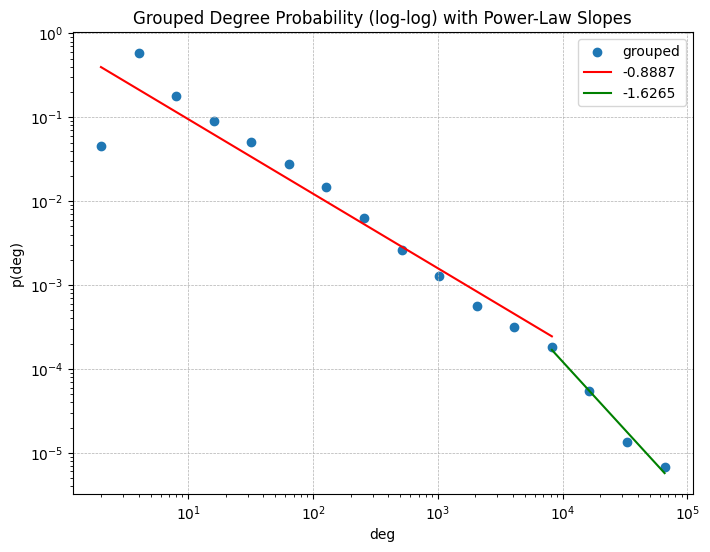

In [9]:
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="lower")
regiment_values = regiment_candidates[4096]
plot_grouped_two_regiments(grouped_dict, 8192, 
                           regiment_values["slope_left"], regiment_values["intercept_left"], 
                           regiment_values["slope_right"], regiment_values["intercept_right"])